# Sentiment Classification - Private Datasets - (Training)

------

**Author:**

- Alan Aboudib: [@twitter](https://twitter.com/alan_aboudib)

-----

## Problem Statement

Suppose you run a deep learning company that provides NLP expertise. You have two clients: Bob and Alice. Each of them runs their own website were users can write reviews about movies that have watched.

Bob and Alice have heard of the great services you provide and asked you to create a sentiment classifier to help them automatically assign a sentiment (positive or negative) to each users review.

Now you think that this is a really good opportunity. If you pool data from both Bob's and Alice's datasets, you would be able to create a bigger dataset that you can use to train a better classifer.

But... 

It turns out you are not allowed to do this; both datasets are private.

You are informed that privacy regulations in both Bob's and Alice's countries, prevents them from revealing their data to any third party. You cannot move Bob's data to your company's machines. Same for Alice's. Each dataset is contrained to live on its owner's machine, and they cannot be mixed together to create a bigger dataset.

Now you think about OpenMined, and their great library called PySyft that provides the possiblity to perform Federated Learning and Encrypted Computations. Without that, you will be able to train a single model on both datasets at the same time. and YOUR ARE RIGHT!

However, ...

As you new, text datasets cannot be consumed directly for training a neural training. You need to create numerical representations of each text review before PySyft can consume it. Text needs to be tokenized first, preprocessed and vector embedding should be used instead of plaintext. But how to do such preprocessing if you are not allowed to have access to plaintext data? 

**SyferText** can help you! With SyferText, you can define preprocessing components that you can send over a network to Bob's and Alice's machine to perform preprocessing remotely, blindly and in a completely secure fashion. SyferText components do all the work from processing plaintext to obtaining its vector representation and encrypting it to hand it over to PySyft models for training. All without you accessing the data, and without the data quitting their owners machine.

If you are wondering how that works, keep on following this tutorial.


**Let's summarize:**

1. You need to create a bigger dataset out of Bob's and Alice's smaller datasets. *(PySyft has the arsenal for that)*

2. You need to prepare and preprocess the text data on Bob's and Alice's machines without revealing it, without moving any datasets to your machine, and without the need to work directly on Bob's or Alice's machines. *(SyferText to the rescue)*

For this tutorial, we are going to work with the IMDB movie review dataset. This is a public dataset. But we are going to break it into two part, send each part to a differet PySyft work. We  consider that each part is a private dataset owned by the PySyft worker.

## -4. Importing libraries

Let's first install and import some libraries that we are going to be used all along this tutorial:

In [68]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements'


In [67]:
# SyferText imports
import syfertext
from syfertext.pipeline import SimpleTagger

# Import useful utility functions for this tutoria
from utils import download_dataset

# PySyft and PyTorch import
import syft as sy
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

# Useful imports
import numpy as np
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import os
from pprint import pprint

sb.set()




## -3. Download the Dataset

<font color='red'> (IGNORE THIS STEP IF YOU HAVE ALREADY DONE IT) </font>


The dataset will be downloaded in a folder called `./imdb` in the same directory as the current notebook's. Four files are going to be downloaded:

- `imdb.csv`: This is the dataset file containing 50K labeled reviews. It is a csv file composed of two columns: `review` and `sentiment`. The `review` column holds the review's text, and the `sentiment` column has one of two values: 'positive' or 'negative' to describe the overall sentiment of the review.
- `stop_word_en.txt`: This is just a text file with a list of stop words according to NLTK.
- `imdb_vocab.txt`: a list of all vocabulary of the dataset. One word per line.
- `imdb_polarity.txt`: It hold the polarity value of each word in `imdb_vocab.txt`. A word that appears more often in positive reviews will have a higher polarity value than one that more frequently encountered in negative reviews.

It is important to note that only the dataset `imdb.csv` is considered private. All other files in the above list are not under any privacy constraints.

Please run the below cell in order to download the dataset.

In [2]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/AlanAboudib/dataset_imdb/master/%s'

# File names to be downloaded from the using the URL template above
files = ['imdb.csv', 'imdb_vocab.txt', 'imdb_polarity.txt', 'stop_word_en.txt']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'imdb'
root_path = './imdb'

# Create the dataset folder if it is not already there
if not os.path.exists('./imdb'):
    os.mkdir('./imdb')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )


Preparing to download dataset: `imdb` ...


imdb: 68.0MB [04:45, 238kB/s]                                


## -2. Preparing the work environment

As I explained in the introduction, we will simulate a work environment with three main actors, a company (me) and two clients owning two private datasets (Bob and Alice). In PySyft terminology, this translates to creating a worker to represent each actor. We will also need a fourth worker, the crypto provider, which provides the primitives for using Secure Multi-Party Encryption (SMPC) that we will apply to encrypt word embeddings and the model itself before training. Here is how we do it with PySyft:

In [2]:
# Create a torch hook for PySyft
hook = sy.TorchHook(torch)

# Create some PySyft workers
me = hook.local_worker # This is the worker representing the deep learning company
bob = sy.VirtualWorker(hook, id = 'bob') # Bob owns the first dataset
alice = sy.VirtualWorker(hook, id = 'alice') # Alice owns the second dataset

crypto_provider = sy.VirtualWorker(hook, id = 'crypto_provider') # provides encryption primitive for SMPC

# Create a summary writer for logging performance with Tensorboard
writer = SummaryWriter()

## -1. Simulating Private Datasets

In order to simulate have two private datasets owned by two different clients, Bob and Alice. We will do the following:

1. Load the whole dataset in `imdb.csv` locally (the `me` worker). This dataset will be loaded as a list of dictionaries that has the following format: `[ {'review': <review text>, 'label': <1 or 0>}, {...}, {...}]`


2. Split the dataset into two parts, one for Bob and the other for Alice. Each part will be also split into a training set and a validation set. This will create four lists: `train_bob`, `valid_bob`, `train_alice`, `valid_alice`. Each listhas the same format I mentioned above.


3. Each element in the four lists will be sent to the corresponding worker. This will change the content of the lists as depicted in **Figure(1)**. Each list willl hold PySyft pointers to the texts and labels instead of the objects themselves.

<br>

<img alt = 'imdb review remote datasets' src ='./art/imdb_review_remote.png' style='width:700px'>

<div>
    
<p style='width:600px;margin:30px auto 10px auto;text-align:center'>
    
    <span style='font-weight:bold'> Figure(1): </span> The reviews and their labels are remotely located on Bob's and Alice's remote machines, only pointers to them are kept by the local worker (the company's machine).
    
</p>
    
</div>

<br>

Let's load the dataset locally:

In [31]:
# Set the path to the dataset file
dataset_path = './imdb/imdb.csv'

# store the dataset as a list of dictionaries
# each dictionary has two keys, 'review' and 'label'
# the 'review' element is a PySyft String
# the 'label' element is an integer with 1 for 'positive'
# and 0 for 'negative' review
dataset_local = []

with open(dataset_path, 'r') as dataset_file:
    
    # Create a csv reader object
    reader = csv.DictReader(dataset_file)
    
    for elem in reader:
        
        # Create one entry
        example = dict(review = String(elem['review']),
                       label = 1 if elem['sentiment'] == 'positive' else 0
                      )
        
        # add to the local dataset
        dataset_local.append(example)

Here is how an element in the list looks like:

In [66]:
example = dataset_local[10]
pprint(example)

{'label': (Wrapper)>[PointerTensor | me:35928650540 -> bob:85041041421],
 'review': 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'}


Let's check out the data types:

In [46]:
print(type(example['review']))
print(type(example['label']))

<class 'syft.generic.pointers.string_pointer.StringPointer'>


This review text is a PySyft `String` object. The label is an integer.

Let's split the dataset into two equal parts and send each part to a different worker simulating two remote datasets as I mentioned above:

In [37]:
# Create two datasets, one for Bob, and the other for Alic
dataset_bob, dataset_alice = train_test_split(dataset_local, train_size = 0.5)

# Now create a validation set for Bob, and another for Alice
train_bob, val_bob = train_test_split(dataset_bob, train_size = 0.7)
train_alice, val_alice = train_test_split(dataset_alice, train_size = 0.7)

And now I will make the dataset remote:

In [39]:
# A function that sends the content of each split to a remote worker
def make_remote_dataset(dataset, worker):

    # Got through each example in the dataset
    for example in dataset:
        
        # Send each review text
        example['review'] = example['review'].send(worker)

        # Send each label as a one-hot-enceded vector
        one_hot_label = torch.zeros(2).scatter(0, torch.Tensor([example['label']]).long(), 1)
        
        # Send the review label
        example['label'] = one_hot_label.send(worker)


Notice that the above function, transforms the label to a one-hot-encoded format before sending it to a remote worker. So if the sentiment is negative, the corresponding tensor will hold `[1,0]`, and if it is positive, the label will be `[0,1]`. I actually choose this representation over a simple `1` or `0` due to some limitations in PySyft at the moment of writing this blogpost. This limitation is being worked on, and will be solved very soon.

I can finally create the remote datasets:

In [40]:
# Bob's remote dataset
make_remote_dataset(train_bob, bob)
make_remote_dataset(val_bob, bob)

# Alice's remote dataset
make_remote_dataset(train_alice, alice)
make_remote_dataset(val_alice, alice)

Let me show you what an element of Bob's dataset look like:

In [49]:
# Take an element from the dataset
example = train_bob[10]

print(type(example['review']))
print(example['label'])

<class 'syft.generic.pointers.string_pointer.StringPointer'>
(Wrapper)>[PointerTensor | me:17018428705 -> bob:81226937210]


Wow, the text type is now a PySyft `StringPointer` that points to the real `String` object  located in Bob's machine. The label type is a PySyft `PointerTensor`. Let's check out the location of the real text and label:

In [50]:
print(example['review'].location)
print(example['label'].location)

<VirtualWorker id:bob #objects:50003>
<VirtualWorker id:bob #objects:50003>


Well, you can see it for yourself, they are located in Bob's machine. This confirms **Figure(1)**.

The datasets are now ready, and so is the work environment. Let's start the fun with SyferText :) 

## 0. Create a `SyferText` Language object

The Language object in SyferText is the master object. It orchestrates all the work done by SyferText. Let's create one:

In [21]:
# Create a Language object with SyferText
nlp = syfertext.load('en_core_web_lg', owner = me)

Whenever you create a Language object as we did above, a pipeline will be created. At initialization, a pipeline only contains a tokenizer. You can see this for yourself using the `pipeline_template` property:

In [24]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'}]

Notice that the tokenizer entry has a propery called `remote` set to `True`. This means that we allow the tokenizer to be sent to a remote worker in case the string to be tokenized live there.

We can add more components to the pipeline by using the `add_pipe` method of the Language class. One component we can add is a `SimpleTagger` object. This is a SyferText object that we can use to set custom attributes to individual tokens. In this tutorial, I will create two such  taggers: One that tags tokens that are stop words, the other tags each token as polar or not. 

By tagging a token, I mean setting a custom attribute to that token and assigning it a given value. For example, I set an attribute called `is_stop` with a value `True` for a stop word, and `False` otherwise.

[Illustration] with me with language model and pipeline with only one subpipeline.

### 0.1 Create a  tagger for stop words

We will start by creating the stop-word tagger. Let's first load the stop word file into a list of words:

In [53]:
# Load the list of stop words
with open('./imdb/stop_word_en.txt', 'r') as f:
    stop_words = set(f.read().splitlines())

Now we create the tagger which is an object of the `SimpleTagger` class:

In [54]:
# Create a simple tagger object to tag stop words
stop_tagger = SimpleTagger(attribute = 'is_stop',
                           lookups = stop_words,
                           tag = True,
                           default_tag = False,
                           case_sensitive = False
                          )

Notice that I pass the list of words as the `lookups` arguments. 

Every token in the `Doc` object will be given a custom attribute called `is_stop`. Every time a stop word is found, this attribute will be given the value `True` specified by the `tag` argument of the `SimpleTagger` class initialiser, otherwise, the `default_tag` will be used, i.e., `False`.

### 0.2 Create a tagger for most polar words

In the same way we created a tagger for stop words. We are now going to create another tagger for polar words, i.e., words that are more biased toward a positive or a negative sentiment. Let's load the corresponding files `imdb_vocab.txt` and `imdb_polarity.txt`:

In [55]:
# Load the polarity info
with open('./imdb/imdb_vocab.txt', 'r') as f:
    imdb_words = f.read().splitlines()
    
with open('./imdb/imdb_polarity.txt', 'r') as f:
    polarity = [float(line) for line in f.read().splitlines()]

Let me show you the distribution of polarity values:

Text(0.5, 1.0, 'Distribution of Polarity Values in the IMDB dataset')

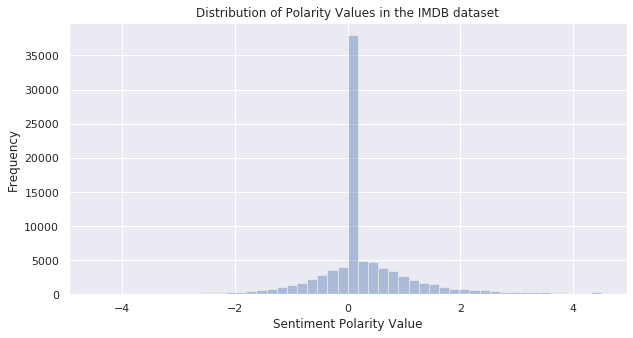

In [56]:
# Create the histogram of polarity values
fig, ax = plt.subplots(figsize = (10,5))
sb.distplot(polarity, kde = False, ax = ax)

ax.set_xlabel('Sentiment Polarity Value')
ax.set_ylabel('Frequency')
ax.set_title("Distribution of Polarity Values in the IMDB dataset")

We notice that the grand majority of words seem to be unbiased toward a specific sentiment. So let's create a tagger that tags only tokens that are most polar by setting a custom attribute we will call `is_polar` to `True` and `False` otherwise:

In [57]:
# Choose low/high polarity cutoff values
low_cutoff = -0.5
high_cutoff = 0.5

# Create a list of polar tokens
polar_tokens = [token for i, token in enumerate(imdb_words) 
                if polarity[i] > high_cutoff or
                polarity[i] < low_cutoff]

Using the list of polar word above, we can now create the tagger:

In [58]:
polarity_tagger = SimpleTagger(attribute = 'is_polar',
                               lookups = polar_tokens,
                               tag = True,
                               default_tag = False,
                               case_sensitive = False
                              )

### 0.3 Adding the taggers to the pipeline

We can add each tagger we created above by using the `add_pipe()` method of the `Language` class. However, in the following cell, I give you the possibility to decide for yourself which components you wish to add.

Here is what I recommend you do:

1- First run this tutorial without adding an tagger.
2- Restart the notebook and run the tutorial again with `use_stop_tagger = True`.
3- Restart the notebook and run the tutorial again with both `use_stop_tagger = True` and `use_polarity_tagger = True`.

I will actually show you the results of each such run at the end of this notebook.

In [59]:
use_stop_tagger = False
use_polarity_tagger = False

# Token with these custom tags
# will be excluded from creating
# the Doc vector
excluded_tokens = {}

Notice that in the above cell. I create a dictionary called `excluded_tokens`. It will be used later in this tutorial when we create embedding vectors for reviews. It enables us to execlude some tokens when we create a document embedding. Such exclusion will be based on the value of the custom attributes we set with the taggers.

Now let's add the stop word tagger to the pipeline (If `use_stop_tagger = True`). Notice that I set the argument `remote = True`. This tells the `Language` object that it is allowed to send the pipe component to the remote worker.

In [60]:
if use_stop_tagger:

    # Add the stop word to the pipeline
    nlp.add_pipe(name = 'stop tagger',
                 component = stop_tagger,
                 remote = True
                )

    # Tokens with 'is_stop' = True are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_stop'] = {True}

Same for adding the polar word tagger:

In [61]:
if use_polarity_tagger:
    
    # Add the polarity tagger to the pipeline
    nlp.add_pipe(name = 'polarity tagger',
                 component = polarity_tagger,
                 remote = True
                )

    # Tokens with 'is_polar' = False are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_polar'] = {False}

Let's check out what pipe components are included in the pipeline:

In [63]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'},
 {'remote': True, 'name': 'stop tagger'}]

-----------

<br>
<img alt = 'SyferText pipeline' src ='./art/imdb_pipeline.png' style='width:700px'>
<div>
<p style='width:600px;margin:30px auto 10px auto;text-align:center'>
    <span style='font-weight:bold'> Figure 2: </span> A pipeline on the local worker only contains pointers to subpipelines carrying out the actual preprocessing on remote workers.
</p>
</div>
<br>

## 1. Create a Dataset class

In [19]:
class DatasetIMDB(Dataset):
    
    def __init__(self, sets, share_workers, crypto_provider, nlp):
        
        self.sets = sets
        self.crypto_provider = crypto_provider
        self.workers = share_workers
    
        # Create a single dataset unifying all datasets
        self._create_dataset()
        
    def __getitem__(self, index):

        # get the example
        example = self.dataset[index]
        
        # Tokenize the string and get a doc pointer
        doc_ptr = nlp(example['review'])
        
        # Get the encrypted vector embedding for the document
        vector_enc = doc_ptr.get_encrypted_vector(bob, 
                                                  alice, 
                                                  crypto_provider = self.crypto_provider,
                                                  requires_grad = True,
                                                  excluded_tokens = excluded_tokens
                                                 )
        
        # The only reason I am expecting an AttributeError
        # here is this PySyft issue in version 0.2.4:
        # https://github.com/OpenMined/PySyft/issues/3261
        # Once the issue is fixed, there would be no need
        # for the try/except statement here.
        try:
            # Encrypte the target label
            label_enc = example['label'].fix_precision().share(bob, 
                                                               alice, 
                                                               crypto_provider = self.crypto_provider,
                                                               requires_grad = True
                                                              ).get()

        except AttributeError:
            
            label_enc = example['label'].share(bob, 
                                               alice, 
                                               crypto_provider = self.crypto_provider,
                                               requires_grad = True
                                              ).get()

        return vector_enc, label_enc

    def __len__(self):
        
        # The size of the combined datasets
        return len(self.dataset)

    def _create_dataset(self):
        """Create a single dataset unifying examples from all remote datasets
        """
        
        # Initialize the dataset
        self.dataset = []
      
        # populate the dataset list
        for dataset in self.sets:
            for example in dataset:
                self.dataset.append(example)
                
    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch
        vectors, targets = list(zip(*batch))

        # concatenate the vectors
        vectors = torch.stack(vectors)
        
        #concatenate the labels
        targets = torch.stack(targets)
        
        return vectors, targets

## 2. Create a DataLoader

Now, I should create the dataset handlers for training and validation as well as data loaders.

This is a key step. You will notice that, although we have two different training sets, I create only one dataset handler for training and only one for validation. 

The training set handler will treat both training sets one bob's and alice's machine as one single big dataset.

When the dataloader creates training batches, these batches will be composed of randomly chosen examples from Bob's and Alice's training sets. What makes mixing datasets in this way possible, without violating privacy, is the fact that those training examples will be encrypted using SMPC with the help of PySyft.

SyferText, makes it possible to process plain text at the remote worker without the need to transfer this data to the model owner's machine (the company in this case). It also allows to encrypt the embedding vectors using PySyft before they quit their home machine.

In [20]:
# Set some hyper parameters
learning_rate = 0.001
batch_size = 32

In [21]:
# Instantiate a training Dataset object
trainset = DatasetIMDB(sets = [train_bob,
                               train_alice],
                       share_workers = [bob, alice],
                       crypto_provider = crypto_provider,
                       nlp = nlp
                      )

# Instantiate a validation Dataset object
valset = DatasetIMDB(sets = [val_bob,
                             val_alice],
                     share_workers = [bob, alice],
                     crypto_provider = crypto_provider,
                     nlp = nlp
                    )

# Instantiate the DataLoader object for the training set
trainloader = DataLoader(trainset, shuffle = True,
                         batch_size = batch_size, num_workers = 0, 
                         collate_fn = trainset.collate_fn)


# Instantiate the DataLoader object for the validation set
valloader = DataLoader(valset, shuffle = True,
                       batch_size = batch_size, num_workers = 0, 
                       collate_fn = valset.collate_fn)



## 3. Create an Encrypted Classifier

In [22]:
class Classifier(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        super(Classifier, self).__init__()
        
        self.fc = torch.nn.Linear(in_features, out_features)
                
    def forward(self, x):
        
        logits = self.fc(x)
        
        probs = F.relu(logits)
        
        return probs, logits

Iniitialize and encrypt the classifier:

In [23]:
classifier = Classifier(in_features = 300, out_features = 2)

# Apply SMPC encryption
classifier = classifier.fix_precision().share(bob, alice, 
                                              crypto_provider = crypto_provider,
                                              requires_grad = True
                                              )
print(classifier)


Classifier(
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


Create an encrypted optimizer

In [24]:
optim = optim.SGD(params = classifier.parameters(),
                   lr = learning_rate).fix_precision()

## 4. Start training

In [ ]:


for epoch in range(2):
    
    for iter, (vectors, targets) in enumerate(trainloader):
        
        # Set train mode
        classifier.train()

        # 1). Zero out previous gradients
        optim.zero_grad()

        # 2). predict sentiment probabilities
        probs, logits = classifier(vectors)

        # 3). Compute loss and accuracy
        loss = ((probs -  targets)**2).sum()#.refresh()# / len(train_data)


        # Get the predicted labels
        preds = probs.argmax(dim=1)
        targets = targets.argmax(dim=1)
        
        accuracy = preds.eq(targets).sum()
        accuracy = accuracy.get().float_precision()
        accuracy = 100 * (accuracy / batch_size)
        
        # 4). Backpropagate the loss
        loss.backward()

        # 5). Update weights
        optim.step()

        # decrypt the loss for logging
        loss = loss.get().float_precision()

        #print(f"Ep {epoch} |  train loss: {loss}, train accuracy {accuracy:2} %")
        
        # Log to tensorboard
        writer.add_scalar('train/loss', loss, epoch * len(trainloader) + iter )
        writer.add_scalar('train/acc', accuracy, epoch * len(trainloader) + iter )

        
        """ Perform validation on exactly one batch """
        
        # Set validation mode
        classifier.eval()

        for vectors, targets in valloader:
            
            
            probs, logits = classifier(vectors)

            loss = ((probs -  targets)**2).sum()

            preds = probs.argmax(dim=1)
            targets = targets.argmax(dim=1)

            accuracy = preds.eq(targets).sum()
            accuracy = accuracy.get().float_precision()
            accuracy = 100 * (accuracy / batch_size)

            loss = loss.get().float_precision()

            # Log to tensorboard
            writer.add_scalar('val/loss', loss, epoch * len(trainloader) + iter )
            writer.add_scalar('val/acc', accuracy, epoch * len(trainloader) + iter )
            
            break
            
writer.close()